<Frame (1080, 1920, 3)>

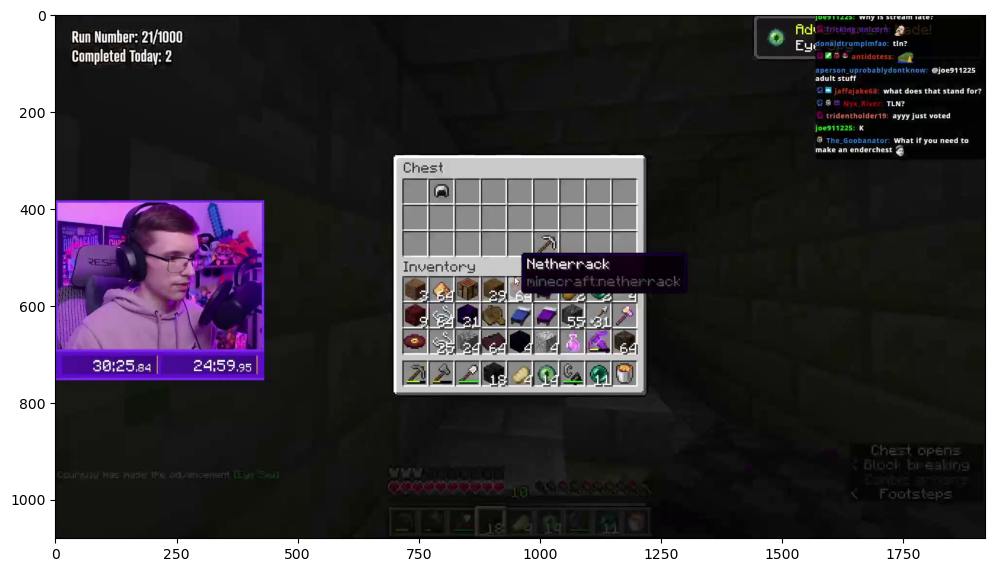

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Video
import ipywidgets as widgets
import pandas as pd
import seaborn as sns
import importlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from src import Frame, Rectangle, VideoReader, VideoWriter

WHITE = (255,255,255)

def group_shapes(rectangles, matches):
    groups = [[rectangles[0]]]    
    
    for rect in rectangles[1:]:
        matching = []
        for group in groups:
            for other in group:
                if matches(rect, other):
                    matching.append(group)
                    break
        if len(matching) == 0:
            groups.append([rect])
        else:
            matching[0].append(rect)
            for other_match in matching[1:]:
                matching[0] += other_match
                del other_match[:]
    
    return sorted(groups, key=len)[::-1]


# vid = VideoReader('tests/videos/live.1.mp4')
# frame = vid[48]
# frame.write('tests/images.chest.2.png')
# vid.release()
frame = Frame.from_file('tests/images/chest.2.png')
frame

In [1]:
vid = VideoReader('tests/videos/live.1.mp4')
with VideoWriter('rectangles.mp4', fourcc='H264', fps=10, size=vid.size) as out:
    for frame in vid:
        img = (frame*0)
        
        mask = frame.median_blur(3).bilateral_filter().hsv_range((0,0,60),(255,40,150))
#         img = mask.cvt_color('gray2bgr') // 2
        contours = mask.find_contours()
        img.draw_contours(contours, color=(150,150,150), replace=True)
        
        rectangles = []
        for contour in contours:
            approx = contour.convex_hull().approx_poly(0.05)
            if len(approx) == 4:
                area = approx.area()
                if area > 10:
                    rect = Rectangle().from_contour(approx, mode='avg')
        #             x,y,w,h = contour.bounding_rect()
        #             print(approx.arcLength() / (w*2+h*2), approx.area() / (w*h))
        #             rect = avg_rect(approx)
                    diff = abs(rect.area-area)
                    if diff / max(rect.area, area) < 0.05:
                        rectangles.append(rect)

        squares = []
        for rect in rectangles:
            ratio = min(rect.width,rect.height) / max(rect.width,rect.height)
            if ratio > 0.95:
                squares.append(rect)

        largest_group = group_shapes(squares, lambda r1, r2: abs(r1.perimeter//2 - r2.perimeter//2) <= 1 and abs(r1.cy - r2.cy) <= 1)[0]

        img.draw_rectangles(largest_group, color=WHITE, thickness=2, replace=True)
        
        out.write(img)
vid.release()

NameError: name 'VideoReader' is not defined

<Frame (520, 560, 3)>

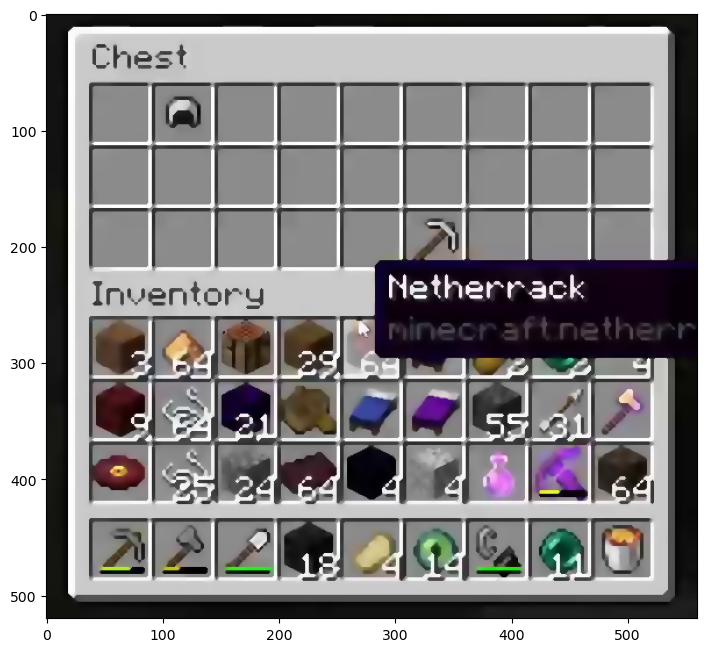

In [9]:
frame[280:-280,680:-680,:].median_blur(3).bilateral_filter()

In [5]:
def find_inventory(frame):
    global squares
    filtered = frame.median_blur(3).bilateral_filter()
    highlights = filtered.hsv_range((0,0,225),(255,255,255))
    shadows = filtered.hsv_range((0,0,40),(255,255,100))
    contours = (highlights | shadows).dilate(kernel=np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=np.uint8)).find_contours()
    approxes = []
    squares = []
    for contour in contours:
        approx = contour.convex_hull().approx_poly(0.05)
        rect = Rectangle().from_contour(approx, mode='bound')
        ratio = min(rect.width,rect.height) / max(rect.width,rect.height)
        # If it is larger than 10px across
        if rect.perimeter//2 > 10 and ratio > 0.97:
            approxes.append(approx)
            squares.append(rect)

#     groups = group_shapes(squares, lambda r1, r2: abs(r1.perimeter//2 - r2.perimeter//2) <= 1)
    img = (frame*0)
    img.draw_contours(contours, color=(70,70,70), replace=True)
    img.draw_contours(approxes, color=(150,150,150), replace=True)
    img.draw_rectangles(squares,color=WHITE, replace=True)
#     img.draw_rectangles(groups[0],color=(255,255,0), replace=True)
    return img

<Frame (520, 560, 3)>

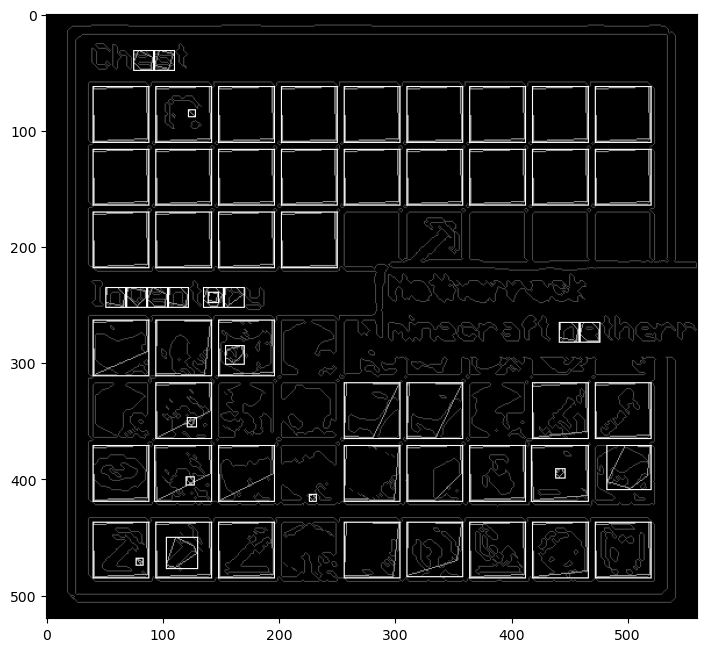

In [6]:
find_inventory(frame[280:-280,680:-680,:])

<Frame (520, 560, 3)>

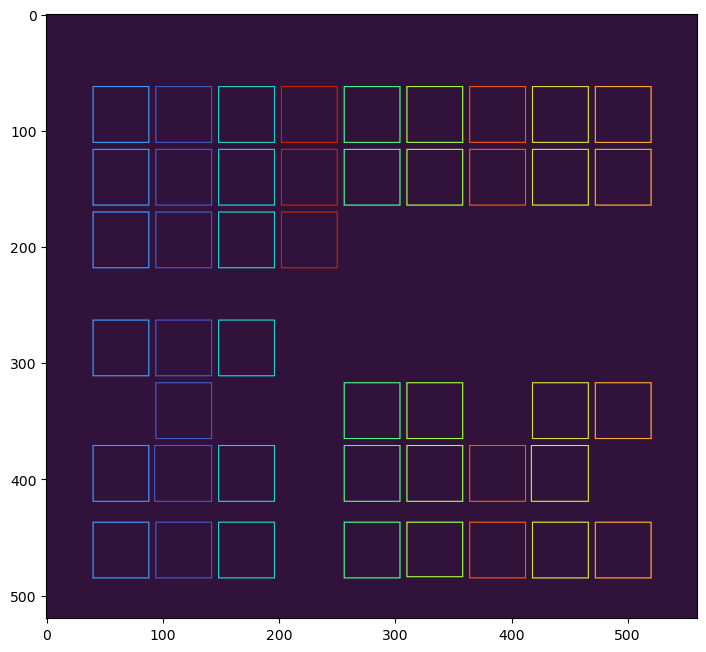

In [15]:
def group_shapes(shapes, conditions):
    groups = [[shapes[0]]]
    
    for shape in shapes:
        any_match = False
        for group in groups:
            matches = True
            for condition in conditions:
                if not condition([*group, shape]):
                    matches = False
                    break
            if matches:
                any_match = True
                group.append(shape)
        if not any_match:
            groups.append([shape])
        
    groups = sorted((group for group in groups if len(group) > 1), key=len)
    return groups[::-1]

def similar_perimeter(shapes):
    perimeters = [shape.perimeter//2 for shape in shapes]
    return max(*perimeters) - min(*perimeters) < 2

def similar_y(shapes):
    ys = [shape.cy for shape in shapes]
    return max(*ys) - min(*ys) < 2

def evenly_spaced(shapes):
#     xs = []
#     for shape in shapes:
#         found = False
#         for other in xs:
#             if abs(other-shape.x) <= 2:
#                 found = True
#         if not found:
#             xs.append(shape.x)
#     xs.sort()
#     if len(xs) == 1:
#         return True
#     spaces = []
#     last = xs[0]
    xs = [shape.cx for shape in shapes]
    min_x = min(*xs)
    xs = [x-min_x for x in xs if abs(x-min_x) > 2]
    
    


img = frame[280:-280,680:-680,:]*0
groups = group_shapes(squares, [similar_perimeter, evenly_spaced])
for i,group in enumerate(groups):
    color = int((i+1)/(len(groups)+1)*255)
    img.draw_rectangles(group, color=(color,color,color), replace=True)
img.apply_colormap('turbo')
# cv.applyColorMap(img, colormap=cv.COLORMAP_TURBO).view(Frame)

In [4]:
vid = VideoReader('tests/videos/live.1.mp4')
with VideoWriter('rectangles.mp4', fourcc='H264', fps=60, size=vid.size) as out:
    for frame in vid:
        out.write(find_inventory(frame))
vid.release()

In [12]:
groups

[[Rect(472, 437, 48, 48),
  Rect(364, 437, 48, 48),
  Rect(310, 437, 48, 48),
  Rect(256, 437, 48, 48),
  Rect(148, 437, 48, 48),
  Rect(94, 437, 48, 48),
  Rect(40, 437, 48, 48),
  Rect(472, 371, 48, 48),
  Rect(364, 371, 48, 48),
  Rect(310, 371, 48, 48),
  Rect(256, 371, 48, 48),
  Rect(148, 371, 48, 48),
  Rect(94, 371, 47, 48),
  Rect(40, 371, 48, 48),
  Rect(418, 371, 48, 48),
  Rect(472, 317, 48, 48),
  Rect(418, 317, 48, 48),
  Rect(364, 317, 48, 48),
  Rect(310, 317, 48, 48),
  Rect(256, 317, 48, 48),
  Rect(202, 317, 48, 48),
  Rect(148, 317, 48, 48),
  Rect(94, 317, 47, 48),
  Rect(40, 317, 47, 48),
  Rect(472, 263, 48, 48),
  Rect(418, 263, 48, 48),
  Rect(364, 263, 47, 48),
  Rect(310, 263, 48, 48),
  Rect(256, 263, 48, 48),
  Rect(148, 263, 48, 48),
  Rect(94, 263, 48, 48),
  Rect(40, 263, 48, 48),
  Rect(202, 263, 48, 48),
  Rect(472, 170, 48, 48),
  Rect(418, 170, 48, 48),
  Rect(364, 170, 48, 48),
  Rect(310, 170, 48, 48),
  Rect(256, 170, 48, 48),
  Rect(202, 170, 48,

<Frame (520, 560, 3)>

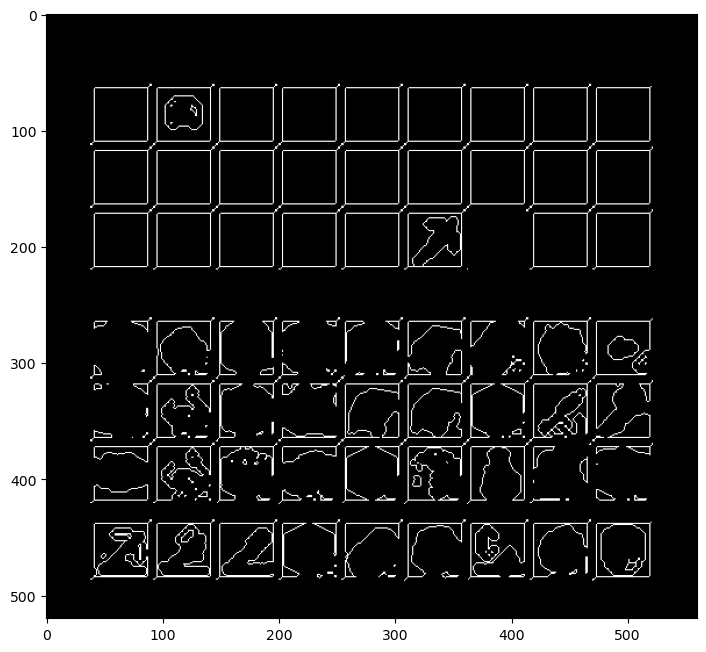

In [169]:
contours = filtered.hsv_range((0,0,120),(255,10,150)).erode(2).find_contours()
# (frame*0)[280:-280,680:-680,:].draw_contours(contours, color=WHITE)

<Frame (520, 560, 3)>

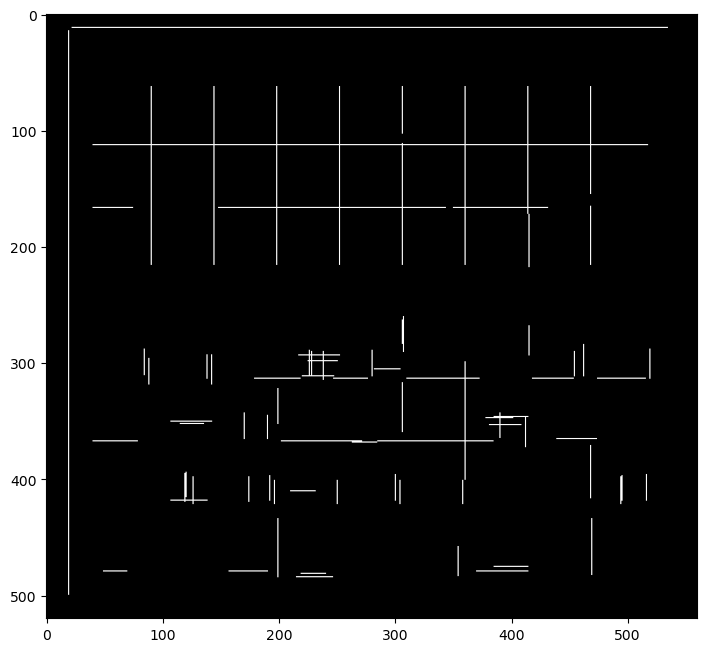

In [51]:
lines = filtered.canny(650).hough_lines(rho=1, theta=2, threshold=None, minLineLength=20, maxLineGap=5)
(frame*0)[280:-280,680:-680,:].draw_lines(lines, color=WHITE)

In [ ]:
filtered.canny(650).hough_lines(rho=1, theta=2, threshold=None, minLineLength=25, maxLineGap=2)

<Frame (120, 560, 3)>

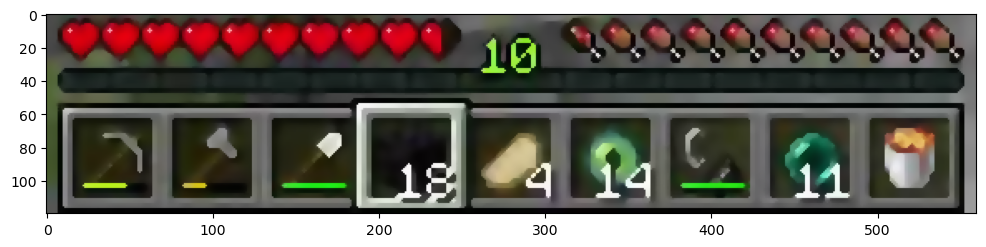

In [4]:
frame[-120:,680:-680,:].median_blur(3).bilateral_filter()

<Frame (120, 560)>

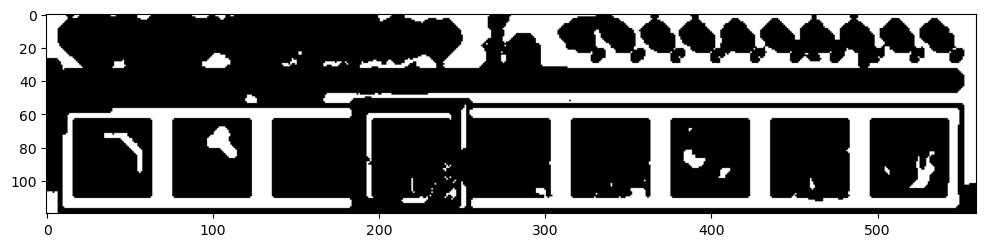

In [69]:
frame[-120:,680:-680,:].median_blur(3).bilateral_filter().hsv_range((0,0,60),(255,40,150))
# frame.median_blur(3).bilateral_filter().hsv_range((0,0,0),(255,255,35))

<Frame (1080, 1920, 3)>

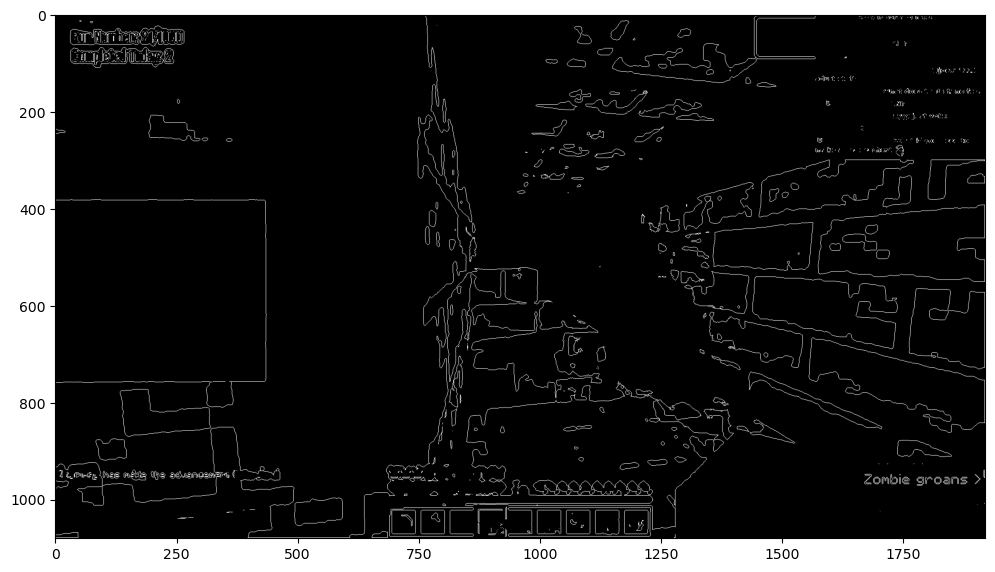

In [2]:
# contours = frame.median_blur(3).bilateral_filter().hsv_range((0,0,0),(255,255,35)).find_contours(mode='external')
contours = frame.median_blur(3).bilateral_filter().hsv_range((0,0,60),(255,40,150)).find_contours()
# frame.draw_contours([contour.approx_poly(0.01) for contour in contours], color=(0,255,0))
(frame*0).draw_contours(contours, color=WHITE)

In [21]:
np.sort([square.y2 for square in squares])

array([   9,  160,  713,  818,  965,  965, 1046, 1070, 1070, 1070, 1070,
       1070, 1070])

In [43]:
group_rectangles(squares)

[[Rect(1176, 1023, 46, 47),
  Rect(1116, 1023, 47, 47),
  Rect(1056, 1023, 47, 47),
  Rect(996, 1023, 47, 47),
  Rect(756, 1023, 47, 47),
  Rect(696, 1023, 47, 47)],
 [Rect(1817, 956, 9, 9), Rect(1691, 956, 9, 9)],
 [Rect(1730, 3, 6, 6)],
 [Rect(1719, 156, 4, 4)],
 [Rect(1770, 569, 149, 144)],
 [Rect(1125, 811, 7, 7)],
 [Rect(721, 1032, 14, 14)]]

In [31]:
pd.DataFrame(((r.x1, r.cx, r.x2, r.y1, r.cy, r.y2) for r in squares), columns=list('lxrtyb'))

,l,x,r,t,y,b
0,1176,1199,1222,1023,1046,1070
1,1116,1139,1163,1023,1046,1070
2,1056,1079,1103,1023,1046,1070
3,996,1019,1043,1023,1046,1070
4,756,779,803,1023,1046,1070
5,696,719,743,1023,1046,1070
6,721,728,735,1032,1039,1046
7,1817,1821,1826,956,960,965
8,1691,1695,1700,956,960,965
9,1125,1128,1132,811,814,818


<Frame (120, 560, 3)>

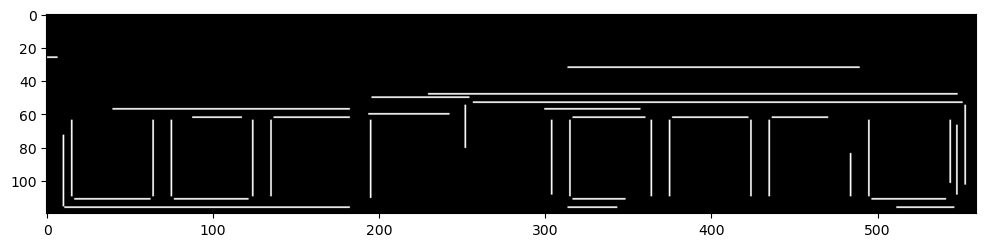

In [74]:
lines = (frame*0).draw_contours(contours, color=WHITE).gray().hough_lines(rho=1, theta=2, threshold=None, minLineLength=25, maxLineGap=2)
(frame*0).draw_lines(lines,color=WHITE)[-120:,680:-680,:]

<Frame (120, 560)>

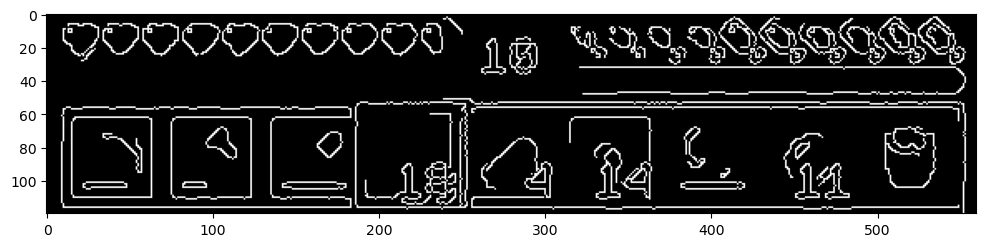

In [25]:
frame[-120:,680:-680,:].median_blur(3).bilateral_filter().canny(250,500)

<Frame (100, 560, 3)>

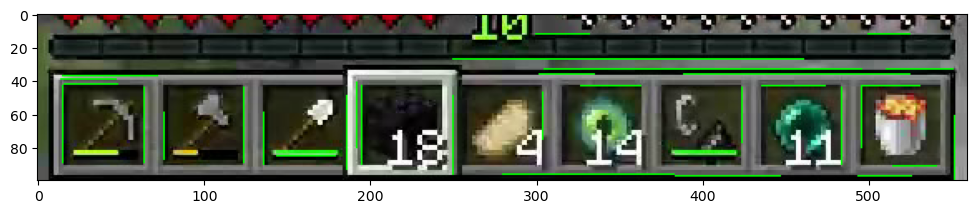

In [5]:
lines = frame.canny(250,500).hough_lines(rho=1, theta=2, threshold=None, minLineLength=25, maxLineGap=1)
frame.draw_lines(lines)[-100:,680:-680,:]

In [34]:
vid[0][-100:,680:-680,:].shape[:2]

(100, 560)

In [4]:
frames = iter(vid)

<Frame (100, 560, 3)>

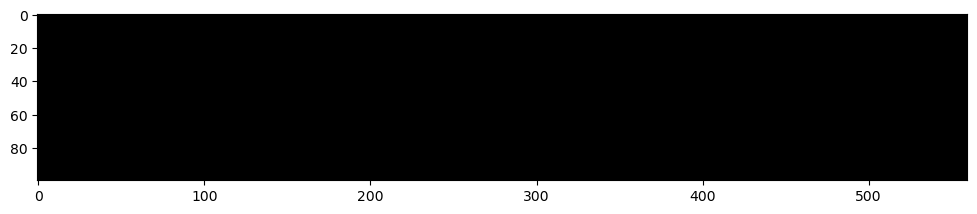

In [65]:
frame = next(frames)
lines = frame.gray().invert().thresh(200,255, 'binary').canny(80,150).hough_lines(rho=1, theta=2, threshold=None, minLineLength=25, maxLineGap=1)
(frame*0).draw_lines(lines, (255,255,255))[-100:,680:-680,:]

jumping from 62 to 61
jumping from 62 to 61
jumping from 62 to 61


<Frame (1080, 1920, 3)>

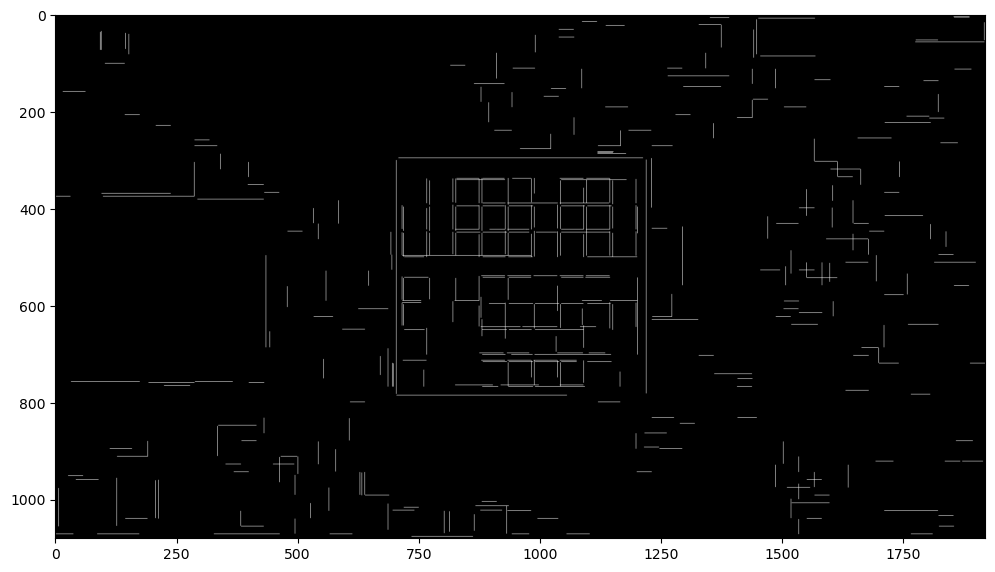

In [138]:
low_sat = vid[61].cvt_color('bgr2hsv')[:,:,1].invert().thresh(200,255,'binary')
whites = vid[61].gray().thresh(240, 255,'binary')
blacks = vid[61].gray().invert().thresh(180, 255,'binary')
# lines = (low_sat & ~whites & ~blacks).canny(80,150).hough_lines(rho=1, theta=2, threshold=None, minLineLength=30, maxLineGap=3)
# (frame*0).draw_lines(lines,color=(255,255,255))
(frame*0).draw_lines((low_sat & (whites | blacks)).canny(80,150).hough_lines(rho=1, theta=2, threshold=None, minLineLength=30, maxLineGap=3),color=(255,255,255))
#[285:-290,694:-694]

<Frame (48, 382)>

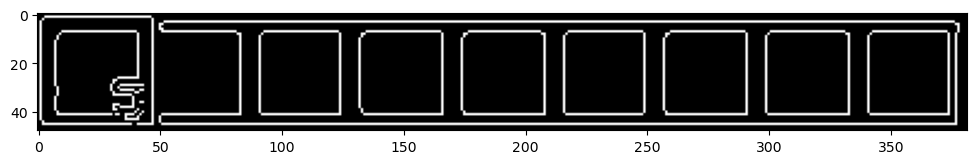

In [190]:
grays.canny(50,180)[-100:,680:-680,:]

<Frame (48, 382)>

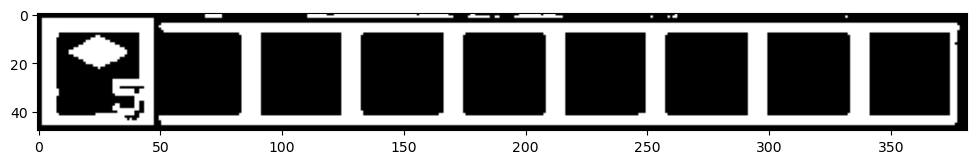

In [138]:
filtered[-100:,680:-680,:].gray().thresh(80,255,'binary')